In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca


#### **Lead-in for Mountain Car Example**

The mountain car problem is a classical control challenge that illustrates the dynamics of a car moving on a slope. This problem is influenced by gravity, the slope's inclination, and an applied acceleration input, as depicted in Figure \ref{fig:mountain_car_problem}. The primary objective is to design a controller using various methods (e.g. LQR, MPC, RL) to drive the car from an initial state $x_0$ to a predefined terminal state $x_T$, adhering to constraints throughout the process. In the first chapter, we will introduce how to implememnt a Dynamical Progamming based controller to achieve this goal.

![Figure 1: Illustration of a mountain car problem](/home/haocheng/core_course_examples/ex1_dynamic_programming/figure/MountainCarIllustration.png)

#### **Part (a): define the mountain car environment**


In this part, we aim to set up the environment for the mountain car problem. The environment consists of defining the terrain profile, mapping the terrain to inclination angles, and specifying task parameters for the controller. The steps include creating a mathematical representation of the terrain, deriving the relationship between the slope and inclination angle, and finally specifying parameters such as the initial state, terminal state, and constraints to uniquely define a control task.

**Step 1: define function that describing the mountain profile $h(p)$ (height $h$ with reference to horizontal position $p$)**

 - case 1: zero slope (linear case): $\quad h(p) = c, p \in [\underline{p}, \overline{p}]$

 - case 2: constant slope (linear case): $\quad h(p) = k \cdot p, p \in [\underline{p}, \overline{p}]$

 - case 3: varying slope (nonlinear case): $\quad h(p) = k \cdot cos(\omega p), p \in [\underline{p}, \overline{p}]$
 
 - case 4: varying slope for under actuated case (nonlinear case): $\quad h(p) = k \cdot sin(\omega p), p \in [\underline{p}, \overline{p}]$

In [2]:
# Define the profile of mountain h(p)
#  - argument: 1) p: CasAdi symbolic expression `p`
#              2) case: integer value to choose the profile of mountain
#  - return: value of `h`

def h(p, case):

    if case == 1:  # zero slope
        h = 0

    elif case == 2: # constant slope
        h = (ca.pi * p) / 18

    elif case == 3: # varying slope
        h = ca.cos(3 * p)

    elif case == 4: # varying slope for underactuated case
        h = ca.sin(3 * p)

    return h


**Step 2: define the mapping from profile $h(p)$ to inclination angle $\theta(p)$**

- Transformation function from $h$ to $\theta$:

   \begin{align*}
     \theta = arctan(\frac{dh}{dp})
   \end{align*}

- Hint: 

  1. with using the CasAdi symbolic expression as the input, we can directly solve the gradient $\frac{dh}{dp}$ with method `ca.jacobian(h, p)`; 

  2. $\theta$ defined in radius;  

- Notice: If the function $h(p)$ is defined numerically rather than symbolically, we can also use **numerical differentiation** to calculate $\frac{dh}{dp}$.

In [3]:
# Calculate inclination angle theta(p) based on terrain profile h(p)
#  - argument: CasAdi symbolic expression `h_func`
#  - return: CasAdi symbolic expression `theta(p)`

def symbolic_theta(h_func):

    p = ca.SX.sym("p")

    h = h_func(p) 
    dh_dp = ca.jacobian(h, p)
    theta = ca.atan(dh_dp)
    
    return ca.Function("theta", [p], [theta])


**Step 3: specify the parameters in environments to uniquely define a task for controller**

- Task: start from given initial position $p_0$, to reach a given target position $p_T$ (Stabilization)

- At last, you can use the pre-defined method `test_env()` to check the slope $h(p)$ and curve of inclination angle $\theta(p)$ as defined in step 2.



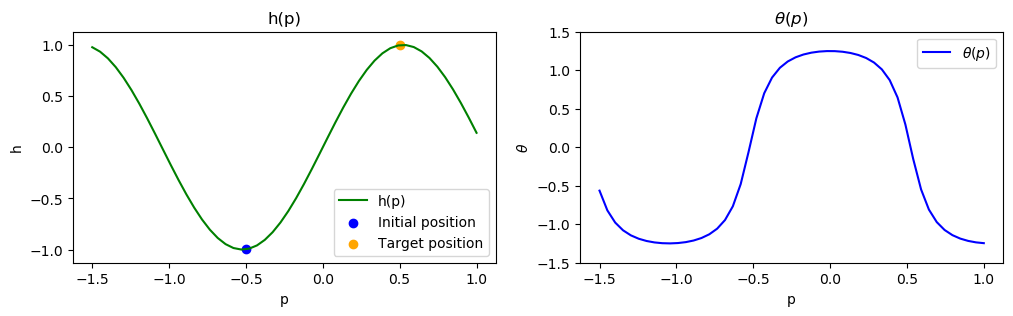

In [4]:
case = 4 # 1, 2, 3, 4

# Define the initial / target state
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.5
target_velocity = 0.0

# Define the state / input constraints
state_lbs = np.array([-1.5, -1.0])
state_ubs = np.array([1.0, 1.0])
input_lbs = -0.5
input_ubs = 1.0

# Instantiate class 'Env'
#  - argument: 1) `case`: $n \in [1, 2, 3, 4]$, type: int
#              2) `initial state`: $x_0 = [p_0, v_0] ^ T$, type: np.array
#              3) `terminal state`: $x_T = [p_T, v_T] ^ T$, type: np.array
#              4) `h`: mountain profile w.r.t. cases (defined in step 1), type: function
#              5) `symbolic_theta`: CasAdi symbolic expression of inclination angle (defined in step 2), type: ca.Function
#              6) constraints on states and inputs:
#                  - `lbx`: $\underline{\boldsymbol{x}} = [\underline{p}, \underline{v}] ^ T$, type: np.array or None (if no related limit)
#                  - `ubx`: $\overline{\boldsymbol{x}} = [\overline{p}, \overline{v}] ^ T$, type: np.array or None (if no related limit)
#                  - `lbu`: $\underline{u}$, type: np.array or None (if no related limit)
#                  - `ubu`: $\overline{u}$, type: float or None (if no related limit)

env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]), h, symbolic_theta, 
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

# Results visualisation
env.test_env() #  shape of slope (left side) and theta curve (right side) 

#### **Part (b): define the system dynamics**

In the previous section, we defined the mountain car environment, including the terrain profile and the mapping from the profile to the inclination angle. In this section, we will define class that describing the system dynamics of the mountain car. This includes specifying the state and input vectors, constructing the dynamics equations using symbolic computation in CasADi, and setting up the dynamics class.


- Notation: 
   - $p$: position in horizontal direction
   - $v$: velocity in horizontal direction
   - $a$: acceleration in body frame (tangent to the slope)

- System dynmaics (in State space representation): 
   - state vector $\boldsymbol{x} = [p, v]^T$
   - input vector $u = a$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} a
   \end{align*}


**Step 1: define the setup function for mountain car dynamics**

- Hints about defining CasADi symbolic expression: 

  1. The variables used for symbolic computation should be declared in datatype `ca.SX` or `ca.MX`;

  2. To package up several variables into a vector, use `ca.vertcat(a, b, ...)`;

  3. To define a CasADi funciton, use `ca.Function("function_name", [input1, input2, ...], [output])`;
  
  4. To call a CasADi funciton, use `function_name(input1, input2, ...))`;

- Supplementary materials:
  
  Introduction to symbolic system in CasADi: https://web.casadi.org/docs/#document-symbolic
  
  API for Python in CasADi: https://web.casadi.org/python-api/
  

In [5]:
# Step2: define dynamics of 1d mountain car
#  - arguments: `theta_function`: CasADi symbolic function of inclination angle `theta_function`, type: ca.Function
#  - return: `dynamics_function`: CasADi symbolic function of dynamics, type: ca.Function

def setup_dynamics(theta_function):

    p = ca.SX.sym("p")
    v = ca.SX.sym("v")
    a = ca.SX.sym("a")
    Gravity = 9.81

    theta = theta_function(p)

    # Expression of dynamics
    dpdt = v
    dvdt = a * ca.cos(theta) - Gravity * ca.sin(theta) * ca.cos(theta)
    
    state = ca.vertcat(p, v)
    input = ca.vertcat(a)
    rhs = ca.vertcat(dpdt, dvdt)

    return ca.Function("dynamics_function", [state, input], [rhs])


**Step 2: specify the arguments for class 'Dynmaics' and instantiate the class**
  
- Notice: symbolic_dynamics depends on the method from external object (theta), therefore, external object 'env' must entry the constructor;

In [6]:
# Define the states and input as symbolic variables
state_names = ["p", "v"]
input_names = ["a"]

# Instantiate class 'Dynamics'
#  - arguments: 1) `env`: object of class `Env`, type: Env
#              2) `state_names`: names of state variables, type: list[str]
#              3) `input_names`: names of input variables, type: list[str]
#              4) `setup_dynamics`: setup function for system dynamics defined in the last step, type: function

dynamics = Dynamics(env, state_names, input_names, setup_dynamics)


#### **Part (C): Implement the Dynamic Programming-based Controller**

Problem formulation (expressed in way of OCP):

$$
J_k(\boldsymbol{x_k}) = \min_{u_{k|k}, \ldots, u_{k+N-1|k}} 
\sum_{i=0}^{N} \left[ \left( \boldsymbol{x_{k+i|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q} \left( \boldsymbol{x_{k+i|k}} - \boldsymbol{x_T} \right) + u_{k+i|k} ^T \boldsymbol{R} u_{k+i|k} \right]
+ \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)
$$

**subject to:**

$$
\boldsymbol{x_{k+i+1|k}} = \boldsymbol{f}_{RK4}(\boldsymbol{x_{k+i|k}}, u_{k+i|k}), \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{1,k+i|k}} \in [-1.2, 0.5], \quad \forall i \in \{0, \ldots, N\}
$$

$$
\boldsymbol{x_{2,k+i|k}} \in [-0.07, 0.07], \quad \forall i \in \{0, \ldots, N\}
$$

$$
u_{k+i|k} \in [-1, 1], \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{1,k|k}} = \boldsymbol{x_{1,k}}, \quad \boldsymbol{x_{2,k|k}} = \boldsymbol{x_{2,k}}
$$



**Step 1: Use Acados to set up the Controller**  

In this step, we will implement the setup function `setup_external()`, which defines the Dynamic Programming-based controller using Acados, a fast and embedded solvers for nonlinear optimal control that provided with Python interfaces. To accomplish this task, we need to sequentially complete defining the model (system dynamics), specifying the optimization problem (cost and constraints), configuring solver settings, and at last initializing the controller and run it to get the optimal policy trajectory from solver.

- Steps: 

  1. **Model Specification**: Setting up the state vectro, input vector and the model (system dynamics derived in section 2)

  - Notice: the system dynamcis we defined in section 2 is a continious-time model, for sake of simplicity, we will descritize this continious time model with Runge-Kutta Method integrated in Acados

  2. **Solver Configuration**: Setting up the Acados solver options, including the prediction horizon, integration method, and QP solver type.

  3. **Cost Function Specification**: 
     - Defining the stage cost using weight matrices `Q`, `R`, and the terminal cost `Qf`. 
     - Configuring mappings from state-input vectors to cost terms using matrices `W`, `Vx`, `Vu`, and reference targets `yref`, `yref_e`.

  4. **Constraint Specification**:
     - State Constraints: Specifying lower and upper bounds for states (`lbx`, `ubx`).
     - Input Constraints: Specifying lower and upper bounds for inputs (`lbu`, `ubu`).
     - Initial State Constraint: Setting the initial state `x0`.

  5. **Solver Initialization and OCP Solving**:
     - Initializing the Acados solver and setting the initial state for the problem.
     - Solving the optimal control problem (OCP).
     - Extracting and storing the optimal inputs into the policy list.

- Supplementary materials:

  API for Python in Acados: https://docs.acados.org/python_interface/index.html
  
  Formulation of optimal control problem in Acados: https://github.com/acados/acados/blob/master/docs/problem_formulation/problem_formulation_ocp_mex.pdf

In [7]:
def setup_external(self):

    # model, state vector, input vector from self.dynamics
    # constraints from self.env

    # Set up model
    model = AcadosModel()
    model.name = "dp_controller"
    model.x = self.dynamics.states
    model.u = self.dynamics.inputs
    model.f_expl_expr = ca.vertcat(self.dynamics.dynamics_function(self.dynamics.states, self.dynamics.inputs))

    # Solver configurations
    ocp = AcadosOcp()
    ocp.model = model
    ocp.dims.N = self.N  # Prediction horizon
    ocp.solver_options.tf = self.N * self.dt  # Total prediction time
    #ocp.solver_options.globalization = 'FUNNEL_L1PEN_LINESEARCH'
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP"
    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"
    #ocp.solver_options.print_level = 1

    # Set up cost function
    ocp.cost.cost_type = "LINEAR_LS"
    ocp.cost.cost_type_e = "LINEAR_LS"
    ocp.cost.W = np.block([
        [self.Q, np.zeros((self.dim_states, self.dim_inputs))],
        [np.zeros((self.dim_inputs, self.dim_states)), self.R],
    ])
    ocp.cost.W_e = self.Qf # will be updated in each step

    # Set up mapping from QP to OCP
    # Define output matrix for non-terminal state
    ocp.cost.Vx = np.block([
        [np.eye(self.dim_states)],
        [np.zeros((self.dim_inputs, self.dim_states))]
    ])
    # Define breakthrough matrix for non-terminal state
    ocp.cost.Vu = np.block([
        [np.zeros((self.dim_states, self.dim_inputs))],
        [np.eye(self.dim_inputs)]
    ])
    # Define output matrix for terminal state
    ocp.cost.Vx_e = np.eye(self.dim_states)

    # Initialize reference of task (stabilization)
    ocp.cost.yref = np.hstack((self.target_state, np.zeros(self.dim_inputs)))
    ocp.cost.yref_e = np.array(self.target_state)

    # Define constraints
    ocp.constraints.x0 = self.init_state  # Initial state
    
    ocp.constraints.idxbx = np.arange(self.dim_states)
    ocp.constraints.idxbx_e = np.arange(self.dim_states)
    ocp.constraints.lbx = np.array(self.env.state_lbs)
    ocp.constraints.ubx = np.array(self.env.state_ubs)
    ocp.constraints.lbx_e = np.array(self.env.state_lbs)
    ocp.constraints.ubx_e = np.array(self.env.state_ubs)
    
    ocp.constraints.idxbu = np.arange(self.dim_inputs)
    ocp.constraints.lbu = np.array(self.env.input_lbs)
    ocp.constraints.ubu = np.array(self.env.input_ubs)

    # Set up Acados solver
    self.ocp = ocp
    self.solver = AcadosOcpSolver(ocp, json_file=f"{model.name}.json")



    # Update initial state in the solver
    self.solver.set(0, "lbx", self.init_state)
    self.solver.set(0, "ubx", self.init_state)

    # Solve the MPC problem
    status = self.solver.solve()
    if status != 0:
        raise ValueError(f"Acados solver failed with status {status}")

    # Extract the inputs
    for k in range(self.N):
        self.policy[k] = self.solver.get(k, "u")
        

**Step 2: Bind the defined DP algorithm to the class "DPController", and run the simulation to see the performance of controller**  

- Steps: 

  1) Bind the defined setup function for DP algorithm `setup_external()` to class `DPController`, it will be automatically called by constructor;

  2) Specify the arguments and instantiate the class `DPController`; 

  3) Instantiate the class `Simulator` and run function `run_simulation()` to generate the simulated state- and input-trajectory;

  4) Instantiate the class `Visualizor`, run function `display_final_results()` and `display_animation()` to show the simulations;


field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_dp_controller.so
rm -f acados_solver_dp_controller.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_dp_controller.o acados_solver_dp_controller.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o dp_controller_model/dp_controller_expl_ode_fun.o dp_controller_model/dp_controller_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/inc

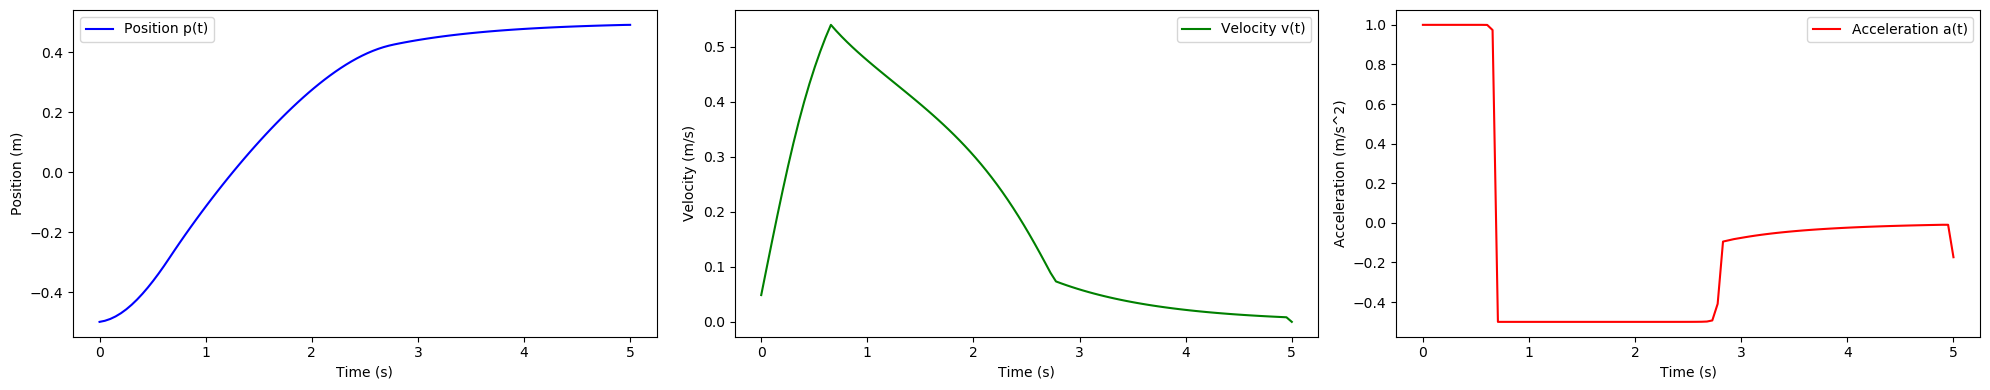

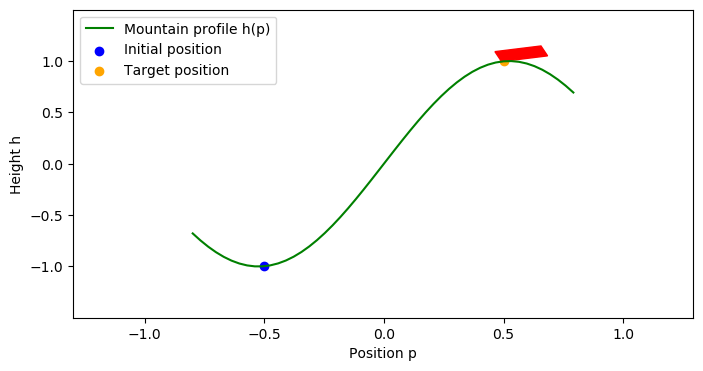

In [ ]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
DPController.setup = setup_external

# Define control frequency of controller and time length of simulation
freq = 20
t_terminal = 5

# Define weight matrix in stage and terminal cost
Q = np.diag([1, 1])
R = np.array([[0]])
Qf = Q

# Instantiate the DP controller class
#  - arguments: 1) `env`: object of class `Env`, type
#               2) `dynamics`: object of class `Dynamics`,
#               3) weight matrices in cost functions:
#                   - `Q`: weight metrix for current state $x_k$ in stage cost $J_s$, type: np.array
#                   - `R`: weight metrix for current input $u_k$ in stage cost $J_s$, type: np.array
#                   - `Q_f`: weight metrix for terminal state $x_N$ in terminal cost $J_f$, type: np.array
#               4) `freq`: control frequency $f$ , type: int
#               5) `horizon`: number of discretized time intervals (i.e. shooting nodes - 1) $N = t_f \times f$, type: int

controller_dp = DPController(env, dynamics, Q, R, Qf, freq, Horizon=t_terminal*freq)

# Instantiate the simulator, and then run the simulation
simulator_dp = Simulator(dynamics, controller_dp, env, 1/freq, t_terminal)
simulator_dp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp = Visualizer(simulator_dp)
visualizer_dp.display_plots()
visualizer_dp.display_animation()
